# Idea

The idea of this notebook was to create the model, which will just classify the images into 'image has not ships' and 'there are ships on the image'. It was planned, that the positive results of this network would be feeded into the model, which perform segmentation (U-Net model).\
Work is still in progress...

# Downloading data from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maksymlytovka","key":"54cd404c9e9594179ea8c3d6df1a189c"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          36895       1033  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           5695        150  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           7477        158  1.0              
mohithsairamreddy/salary-data 

In [ ]:
! kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [22:55<00:00, 22.5MB/s]
100% 28.6G/28.6G [22:55<00:00, 22.3MB/s]


In [ ]:
! mkdir airbus-ship-detection

In [ ]:
! unzip airbus-ship-detection.zip -d airbus-ship-detection


Streaming output truncated to the last 5000 lines.
  inflating: airbus-ship-detection/train_v2/f9775b70e.jpg  
  inflating: airbus-ship-detection/train_v2/f977a470c.jpg  
  inflating: airbus-ship-detection/train_v2/f9780bfaf.jpg  
  inflating: airbus-ship-detection/train_v2/f9782bdfe.jpg  
  inflating: airbus-ship-detection/train_v2/f9785ca49.jpg  
  inflating: airbus-ship-detection/train_v2/f9785e462.jpg  
  inflating: airbus-ship-detection/train_v2/f97a719d5.jpg  
  inflating: airbus-ship-detection/train_v2/f97afa376.jpg  
  inflating: airbus-ship-detection/train_v2/f97b85e3e.jpg  
  inflating: airbus-ship-detection/train_v2/f97bd0b11.jpg  
  inflating: airbus-ship-detection/train_v2/f97bd6b80.jpg  
  inflating: airbus-ship-detection/train_v2/f97bfb1b2.jpg  
  inflating: airbus-ship-detection/train_v2/f97c8cbbe.jpg  
  inflating: airbus-ship-detection/train_v2/f97cdd397.jpg  
  inflating: airbus-ship-detection/train_v2/f97d92e1e.jpg  
  inflating: airbus-ship-detection/train_v2/f97da

# Import and constants

In [ ]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import gc; gc.enable()

directory_path = "airbus-ship-detection"
train_path = os.path.join(directory_path, 'train_v2')
test_path = os.path.join(directory_path, 'test_v2')

In [ ]:
BATCH_SIZE = 4
EDGE_CROP = 16
# number of epochs
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 600
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
# whether we will adjust brightness or not
AUGMENT_BRIGHTNESS = False

# Needed encoding/decoding functions

The functions for Run-Length decoding and encoding

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# This one will be needed further to decode pixels into an image.
# It decodes ALL masks of the image in one go.
def masks_as_image(in_mask_list: np.array):
    '''
    Takes the list of the masks (ships) and create a single mask array for all ships.
    Returns numpy array, in which 0 element is a needed encoding (1 - mask, 0 - background)
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)

    for mask in in_mask_list: # going throug all masks
        if isinstance(mask, str):
            # if mask in str type, then decode and add
            all_masks += rle_decode(mask)

    return np.expand_dims(all_masks, -1)

# Importing data

In [ ]:
masks = pd.read_csv(os.path.join(directory_path, 'train_ship_segmentations_v2.csv'))
masks.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [ ]:
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], "unique ImageId's")

231723 masks found
192556 unique ImageId's


From that we can see the encoding used. As ids are repeating, we have one ship per row, but not one image per row 

In [ ]:
masks['ImageId'].value_counts()

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

The result above confirms our assumptions

In the next cell I am just exploring the data and checking the decoding funstion.

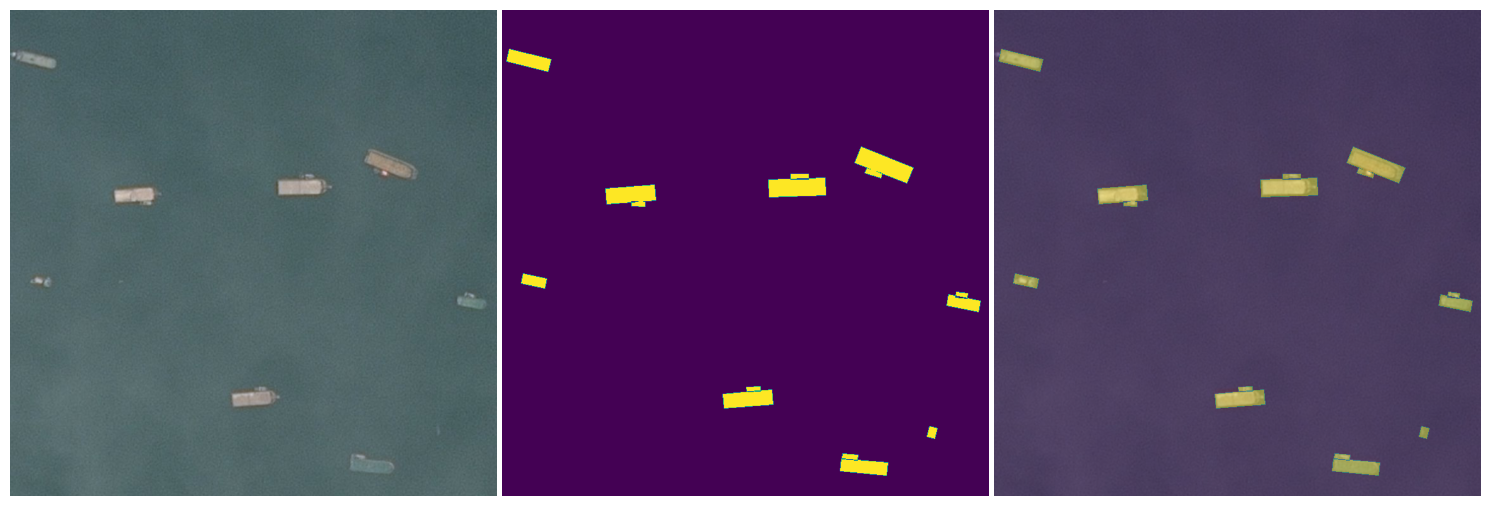

In [ ]:
photo_id = 'c8e722430.jpg'
photo_ships = imread(os.path.join(train_path, photo_id))
photo_ships_masks = masks.loc[masks['ImageId'] == photo_id, 'EncodedPixels'].tolist()

mask_array = np.zeros((768, 768))
for mask in photo_ships_masks:
    mask_array += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(photo_ships)
axarr[1].imshow(mask_array)
axarr[2].imshow(photo_ships)
axarr[2].imshow(mask_array, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.4)
plt.show()

# Splitting train set into train and validation set

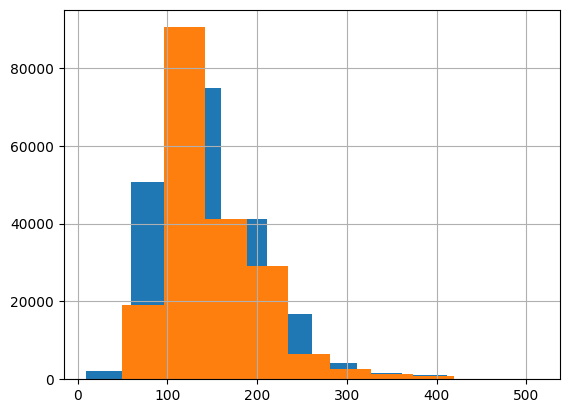

In [ ]:
# creating a new column with the indication thether there are ship on the picture (1) or no (0)
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
# creating a new DataFrame, in which information is grouped by the id of the image
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
# we create a new column with the 1 if image has ships on it and 0 otherwise
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1 if x>0 else 0)
# filter files that are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join(train_path,
                                                                                    c_img_id)).st_size/1024)

unique_img_ids['file_size_kb'].hist() # that's before the filtering (blue)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
# that is beacuse files with the size smaller than 50kb are probably corrupted
unique_img_ids['file_size_kb'].hist() # after the filtering (orange)
masks.drop(['ships'], axis=1, inplace=True)

In [ ]:
unique_img_ids.sample(5)

ImageId  ships  has_ship  file_size_kb
154018  ccca23071.jpg      0         0    367.901367
5640    07912c60a.jpg      0         0    197.479492
12272   104083aa3.jpg      1         1    188.099609
143129  be4b05d86.jpg      1         1    107.308594
175406  e94837102.jpg      1         1    192.382812

We do a stratified sampling based on the presence of the ships ('has ship') column

In [ ]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(unique_img_ids,
                 test_size = 0.1,
                 stratify = unique_img_ids['has_ship'])

# JOIN of the initial dataframe and a new ones
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

207092 training masks
22990 validation masks


In [ ]:
train_df['ImageId'].value_counts()

a8b38c84d.jpg    15
4ea5a8a2f.jpg    15
b8a732575.jpg    15
ad5092ca2.jpg    15
0368beab8.jpg    15
                 ..
591dafc85.jpg     1
591ed5ffd.jpg     1
591f90c54.jpg     1
591fbba15.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 172160, dtype: int64

In [ ]:
train_df.head()

ImageId                                      EncodedPixels  ships  \
0  00003e153.jpg                                                NaN      0   
1  0001124c7.jpg                                                NaN      0   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      5   

   has_ship  file_size_kb  
0         0    128.944336  
1         0     76.059570  
2         1    147.625977  
3         1     75.221680  
4         1     75.221680

<Axes: >

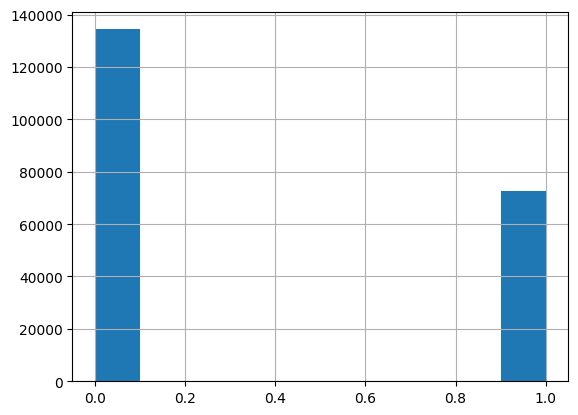

In [ ]:
train_df['has_ship'].hist()

As we can see, we have much more pictures with the ships. Almost twice as much as without them. We will balance the dataset in the next section 

In [ ]:
n_pictures_w_ships = train_df['has_ship'].value_counts()[1]
n_pictures_w_ships

72728

# Undersample 0-images (with no ships)

<Axes: >

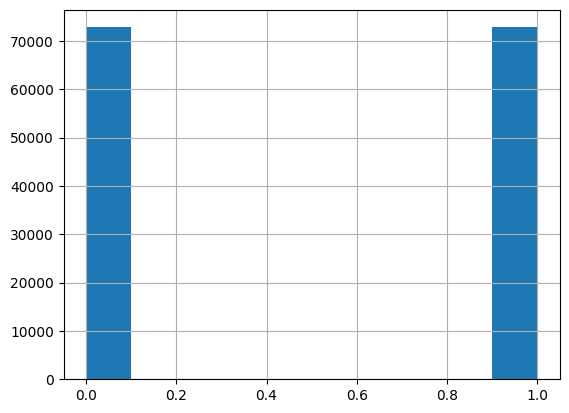

In [ ]:
def sample_ships(in_df, base_rep_val=n_pictures_w_ships):
    return in_df.sample(base_rep_val)

balanced_train_df = train_df.groupby('has_ship').apply(sample_ships)
balanced_train_df['has_ship'].hist()



So now we have equal amount of pictures with and without the ships.

<Axes: >

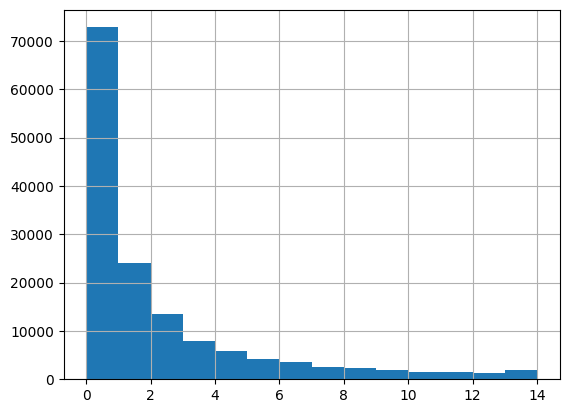

In [ ]:
balanced_train_df['ships'].hist(bins=np.arange(15))


Here I was just interested in the distribution of the number of ships on the picture

In [ ]:
balanced_train_df.loc[balanced_train_df['has_ship'] == 1]["ImageId"].value_counts()

b8a732575.jpg    15
c02a1ee0a.jpg    15
b2c2f7529.jpg    15
2531669aa.jpg    15
f7e6819bb.jpg    15
                 ..
b9e92b878.jpg     1
3e466aaa9.jpg     1
74775c084.jpg     1
da0574d11.jpg     1
3b338c3f4.jpg     1
Name: ImageId, Length: 37796, dtype: int64

# Decoding RLE into numbers

In [ ]:
list(balanced_train_df.groupby('ships'))[0][1]

ImageId EncodedPixels  ships  has_ship  file_size_kb
has_ship                                                                   
0        21354   1a9b259aa.jpg           NaN      0         0    133.447266
         119955  941be8174.jpg           NaN      0         0    196.585938
         115634  8ec0dcfd1.jpg           NaN      0         0     87.662109
         14222   119414fdb.jpg           NaN      0         0    197.496094
         10671   0d21b1c98.jpg           NaN      0         0    115.907227
...                        ...           ...    ...       ...           ...
         141884  af26f6956.jpg           NaN      0         0     90.936523
         49312   3d4f02bcc.jpg           NaN      0         0    103.388672
         41938   3436558ca.jpg           NaN      0         0    129.497070
         195525  f1b030c24.jpg           NaN      0         0    142.736328
         85484   697407583.jpg           NaN      0         0    127.016602

[72803 rows x 5 columns]

In [ ]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_class = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_class in all_batches:
            rgb_path = os.path.join(train_path, c_img_id)
            c_img = imread(rgb_path)
            group = c_class['has_ship'].iloc[0]

            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]

            out_rgb += [c_img]
            out_class += [group]


            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_class, 0)
                out_rgb, out_class=[], []

Creating a generator to produce the pictures we will feed into the CNN

## Train images

In [ ]:
mask_image_generator = make_image_gen(balanced_train_df)
train_x, train_y = next(mask_image_generator)
print('X', train_x.shape, train_x.min(), train_x.max())
print('Y', train_y.shape, train_y.min(), train_y.max())

NameError: ignored

Nevermind the error. With the next run it will be gone 

In [ ]:
train_x[0]

array([[[0.38039216, 0.45098039, 0.5372549 ],
        [0.39607843, 0.46666667, 0.55294118],
        [0.40392157, 0.4745098 , 0.55294118],
        ...,
        [0.18431373, 0.25882353, 0.28627451],
        [0.18823529, 0.2627451 , 0.29019608],
        [0.16078431, 0.23137255, 0.27058824]],

       [[0.2745098 , 0.34117647, 0.41176471],
        [0.30980392, 0.37647059, 0.44705882],
        [0.34901961, 0.41568627, 0.47843137],
        ...,
        [0.20784314, 0.28235294, 0.30980392],
        [0.15294118, 0.22745098, 0.25490196],
        [0.09019608, 0.16078431, 0.2       ]],

       [[0.19607843, 0.25098039, 0.30196078],
        [0.22745098, 0.28235294, 0.33333333],
        [0.26666667, 0.32156863, 0.36470588],
        ...,
        [0.26666667, 0.33333333, 0.36470588],
        [0.21176471, 0.27843137, 0.30980392],
        [0.15294118, 0.21960784, 0.25882353]],

       ...,

       [[0.04705882, 0.10196078, 0.11372549],
        [0.05882353, 0.11372549, 0.1254902 ],
        [0.06666667, 0

In [ ]:
train_y[0]

0

Printing to check the function

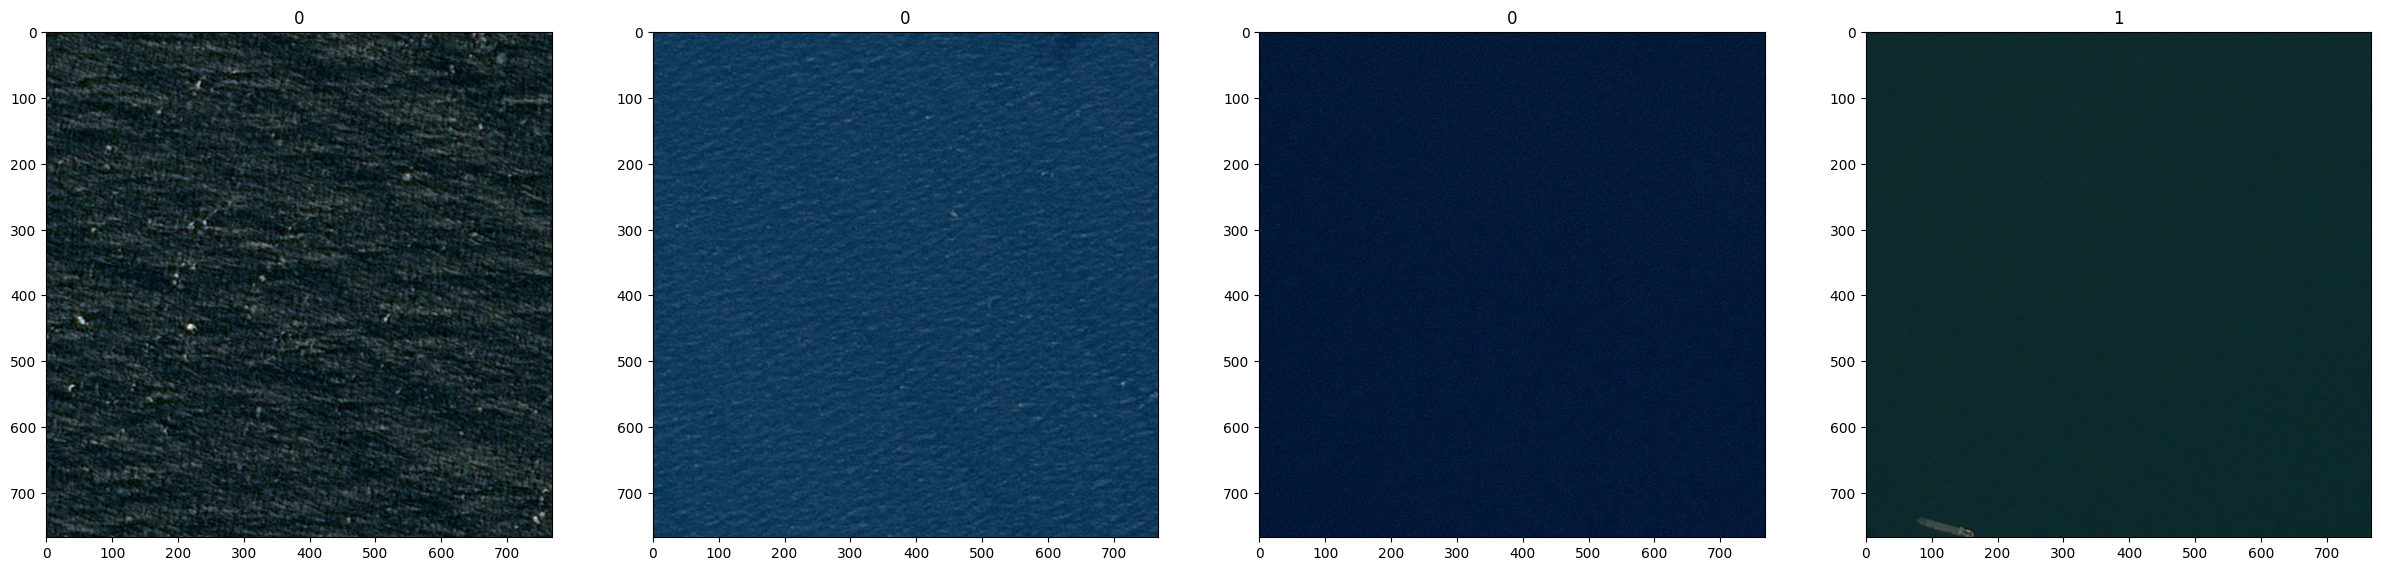

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (30, 10))
ax1.imshow(train_x[0])
ax1.set_title(str(train_y[0]))
ax2.imshow(train_x[1])
ax2.set_title(str(train_y[1]))
ax3.imshow(train_x[2])
ax3.set_title(str(train_y[2]))
ax4.imshow(train_x[3])
ax4.set_title(str(train_y[3]))

plt.show()

## Validation images

We also make the same for the validation set. Note, that we are now using the different constant. Namely, the size of the validation set "VALID_IMG_COUNT". That is the amount of pictures on which CNN will check its accuracy.

In [ ]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(600, 768, 768, 3) (600,)


In [ ]:
gc.collect()

40

# Data Augmentation

We also do data augmentation to expand our dataset, using keras (tensorflow) backend

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        gen = image_gen.flow(in_x,
                             in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(gen)

In [ ]:
full_gen = create_aug_gen(mask_image_generator)
train_full_x, train_full_y = next(full_gen)

In [ ]:
print('x', train_full_x.shape, train_full_x.dtype, train_full_x.min(), train_full_x.max())
print('y', train_full_y.shape, train_full_y.dtype, train_full_y.min(), train_full_y.max())

x (4, 768, 768, 3) float32 0.0 1.0
y (4,) int64 0 1


We do that only for the train set as we don't need any augmentation for the validation or the test set.

And here I am just checking whether evrything is working

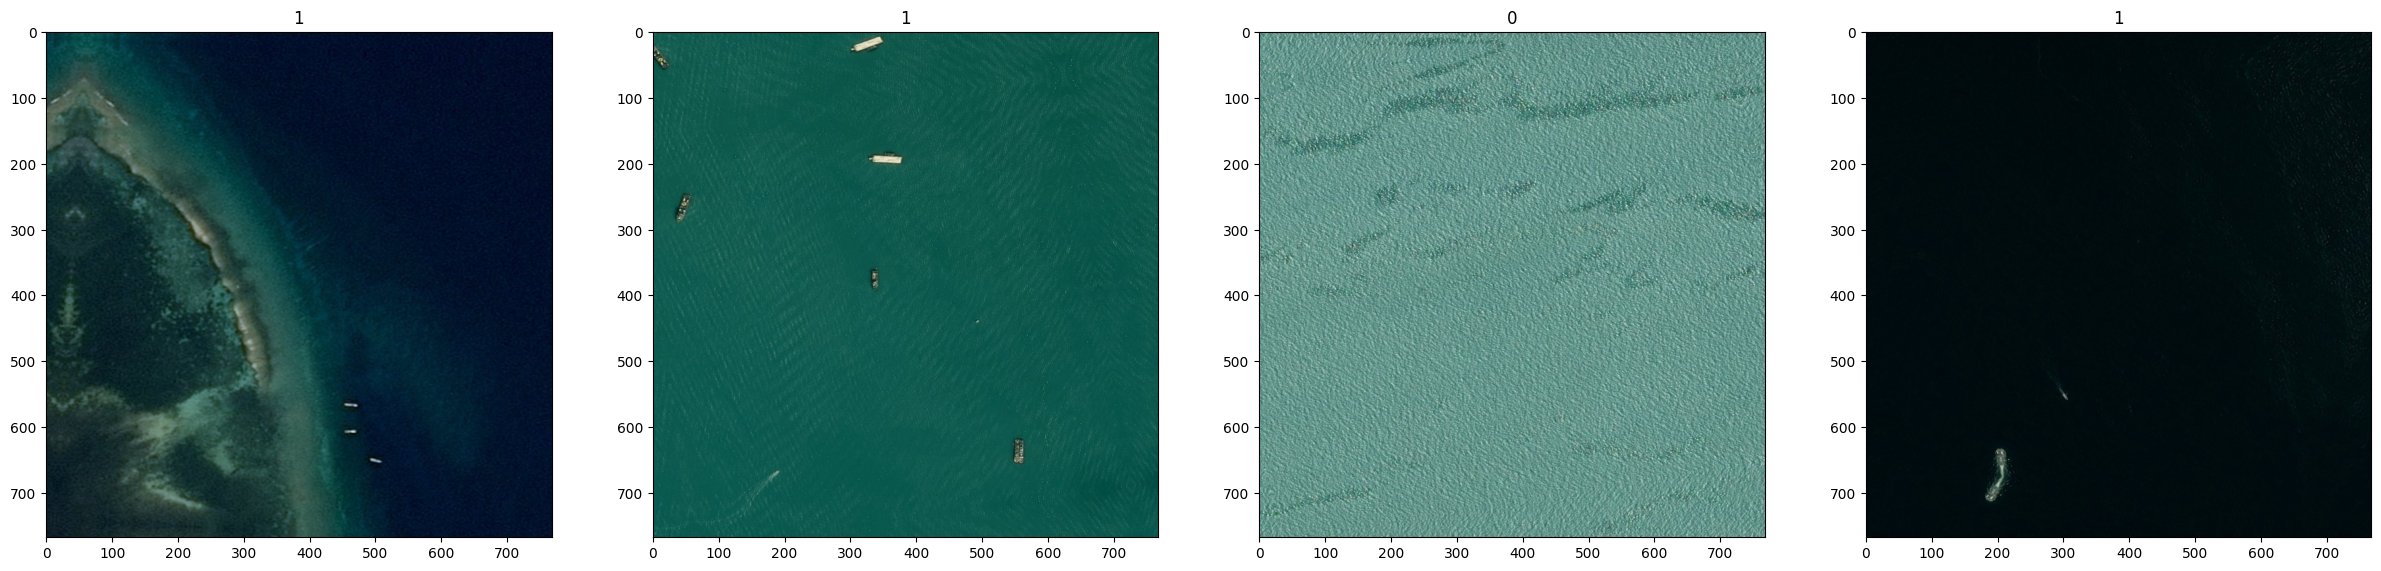

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (30, 10))
ax1.imshow(train_full_x[0])
ax1.set_title(str(train_full_y[0]))
ax2.imshow(train_full_x[1])
ax2.set_title(str(train_full_y[1]))
ax3.imshow(train_full_x[2])
ax3.set_title(str(train_full_y[2]))
ax4.imshow(train_full_x[3])
ax4.set_title(str(train_full_y[3]))

plt.show()

In [ ]:
gc.collect()

14280

# Model

The model with 4 concolutional layers architecture. This is the classification model, that is why the output of the last dense layer is one-dimensional.

In [ ]:
from keras import models, layers


input_img = layers.Input(train_full_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
p2 = layers.MaxPooling2D((2, 2)) (c2)
d2 = layers.Dropout(0.25) (p2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (d2)
p3 = layers.MaxPooling2D((2, 2)) (c3)
d3 = layers.Dropout(0.3) (p3)

c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (d3)
p4 = layers.MaxPooling2D((2, 2)) (c4)
d4 = layers.Dropout(0.3) (p4)

f = layers.Flatten() (d4)

den5 = layers.Dense(32, activation='relu') (f)
d5 = layers.Dropout(0.25) (den5)

final_den = layers.Dense(1, activation='softmax') (d5)

class_model_1 = models.Model(inputs=[input_img], outputs=[final_den])
class_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 768, 768, 3)      0         
 se)                                                             
                                                                 
 batch_normalization (BatchN  (None, 768, 768, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 768, 768, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 384, 384, 8)      0         
 )                                                               
                                                             

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall

precision_metric = Precision()
recall_metric = Recall()

class_model_1.compile(optimizer=Adam(1e-4, decay=1e-6), loss=binary_crossentropy, metrics=['binary_accuracy', precision_metric, recall_metric])


# Monitoring of training

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# we want to save the best weights on each step
weight_path="{}_weights.best.hdf5".format('seg_model')

# This callback actually saves the best model, basing on the binary_accuracy results
checkpoint = ModelCheckpoint(weight_path, monitor='binary_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

# This callback reduces the learning rate when we are entering the plateau. 
# Such method showed good results
reduceLROnPlat = ReduceLROnPlateau(monitor='binary_accuracy', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

# This callback will stop the CNN training if we have no improvements for 'patience' epochs
early = EarlyStopping(monitor="binary_accuracy",
                      mode="max",
                      patience=25)

callbacks_list = [checkpoint, early, reduceLROnPlat]

## Let's GO (training)

The number of epochs I used is not sufficient, but I just wanted to see how network will behave in the early stages

In [ ]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

In [ ]:
loss_history = [class_model_1.fit(aug_gen,
                             steps_per_epoch=step_count,
                             epochs=NB_EPOCHS,
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1
                                       )]

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.6840 - binary_accuracy: 0.3475 - precision: 0.3475 - recall: 1.0000
Epoch 1: binary_accuracy improved from 0.22875 to 0.34750, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 150s 753ms/step - loss: 0.6840 - binary_accuracy: 0.3475 - precision: 0.3475 - recall: 1.0000 - val_loss: 0.6768 - val_binary_accuracy: 0.2417 - val_precision: 0.2417 - val_recall: 1.0000 - lr: 5.0000e-05
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.6843 - binary_accuracy: 0.3600 - precision: 0.3600 - recall: 1.0000
Epoch 2: binary_accuracy improved from 0.34750 to 0.36000, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 138s 691ms/step - loss: 0.6843 - binary_accuracy: 0.3600 - precision: 0.3600 - recall: 1.0000 - val_loss: 0.6759 - val_binary_accuracy: 0.2417 - val_precision: 0.2417 - val_recall: 1.0000 - lr: 5.0000e-05
Epoch 3/5
200/200 [=

As I noticed, it quickly learned to mark everything as 1 (that is why we have this incredible recall of 1). However, maybe with the higher number of epochs this will be resolved

## Results of the training

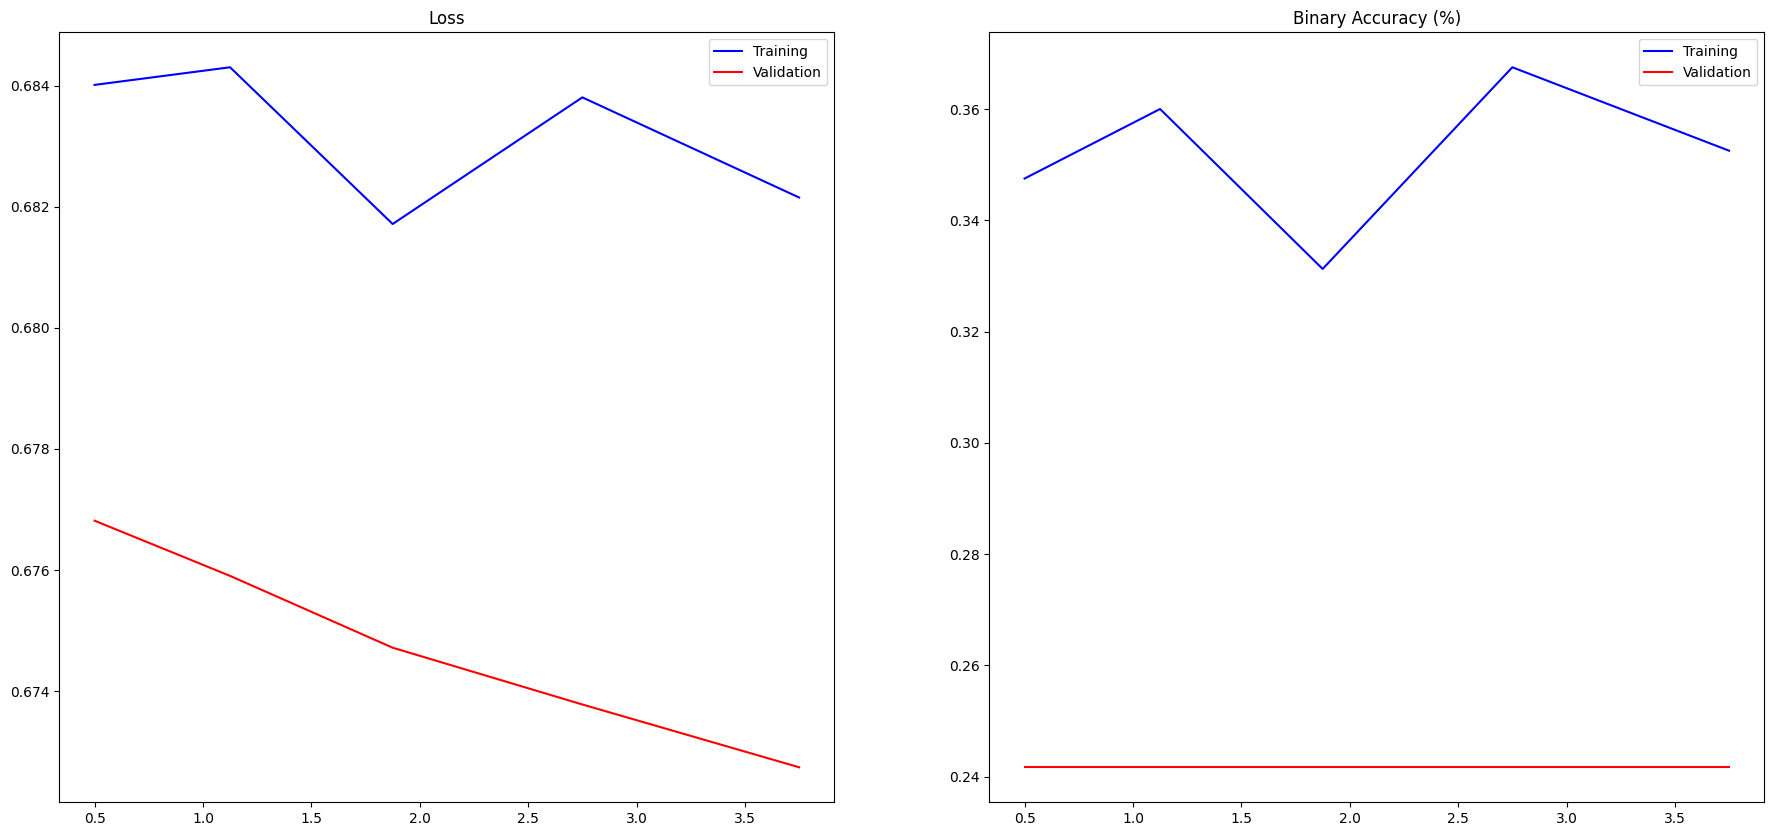

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')


    _ = ax2.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

## Saving

In [ ]:
class_model_1.load_weights(weight_path)
class_model_1.save('class_model_1.h5')

### ... and any resolution model

In case we want to upload imgaes of some other resolution. That way we will have scaling right inside the model

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(class_model_1)
else:
    fullres_model = class_model_1

fullres_model.save('class_model_1_fullres.h5')

# Importing the model

On this step I usually was run out of ram to perform final validation and saving of the results. That is why I imported the model

In [ ]:
os.listdir()

['.config',
 'airbus-ship-detection.zip',
 'class_model_1_fullres.h5',
 'seg_model_weights.best.hdf5',
 'airbus-ship-detection',
 'class_model_1.h5',
 'kaggle.json',
 'sample_data']

In [ ]:
from keras import models, layers


if not 'class_model_1' in globals():
    class_model_1 = models.load_model('class_model_1.h5', compile=False)
    class_model_1.load_weights('class_model_weights.best.hdf5')

# Valuation

Just a small final valuation to see what we have got

In [ ]:
gc.collect()

586

In [ ]:
final_valid_x, final_valid_y = valid_x, valid_y

In [ ]:
final_valid_prediction = class_model_1.predict(final_valid_x)

19/19 [==============================] - 13s 137ms/step


In [ ]:
final_valid_prediction

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [ ]:
from sklearn.metrics import confusion_matrix

result = confusion_matrix(final_valid_y, final_valid_prediction)
result

array([[  0, 494],
       [  0, 106]])

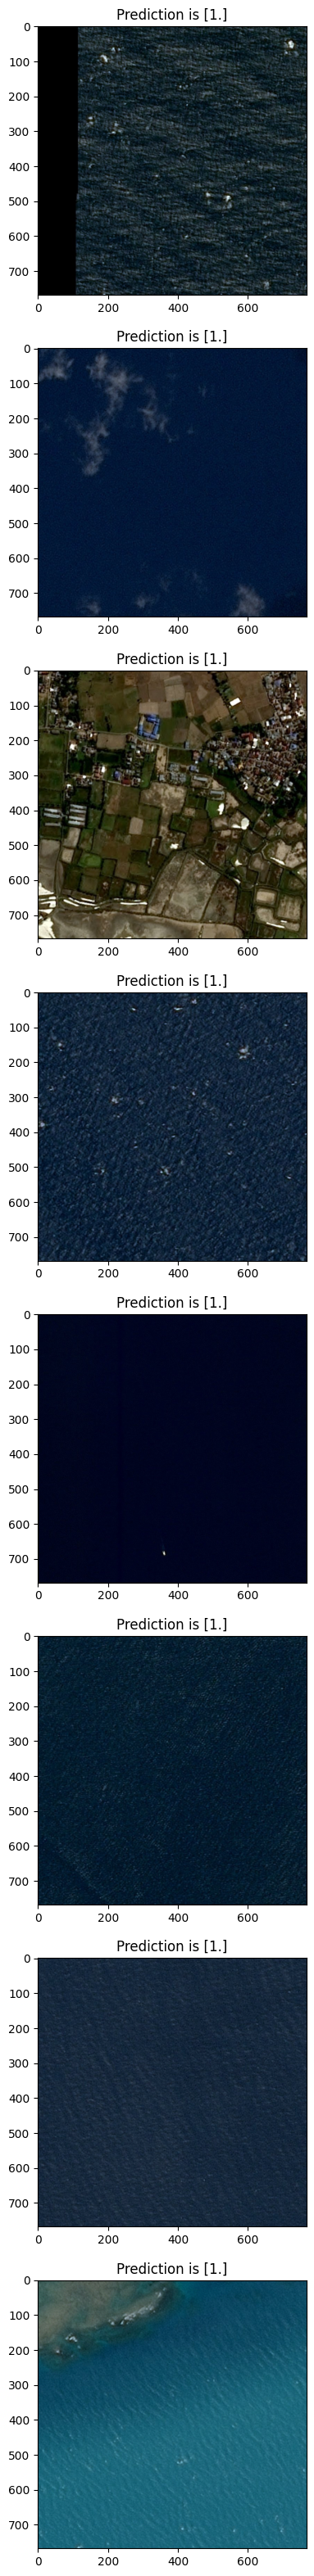

In [ ]:
fig, m_axs = plt.subplots(8, 1, figsize = (10, 40))

for ax1, image, prediction in zip(m_axs, final_valid_x, final_valid_prediction):
    ax1.imshow(image)
    ax1.set_title('Prediction is {}'.format(prediction))

fig.savefig('predictions_validation.png')

# Results

As we may see, the network is just putting 1 on every image. That is from where recall 1 comes froms.\
This may be fixed with the higher number of epochs during the training. However, this options was not tried out yet